In [1]:
%matplotlib inline
%load_ext rpy2.ipython
import os

GIMME_DIR = "/Volumes/WorkDrive/gimmeSAD"
SIMOUT_DIR = os.path.join(GIMME_DIR, "new_sims/")
OBSERVED_FILE = os.path.join(GIMME_DIR, "brent_spider_data/spider.obs")

os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import glob

## Gather all the simulations into one huge simout file

In [30]:
REF_TABLE = os.path.join(SIMOUT_DIR, "priors.txt")
outfile = open(REF_TABLE, "w")

files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
numsims = 0
outfile.write(open(files[0]).readlines()[0])
for f in files:
    lines = open(f).readlines()[1:]
    numsims += len(lines)
    outfile.write("".join(lines))
    outfile.write("\n")
outfile.close()

print("Processed {} simulations.".format(numsims))

Processed 15074 simulations.


## Do the abc in R cuz python abc packages suck
https://www.datacamp.com/community/blog/jupyter-notebook-r#gs.CkjgxoE

In [31]:
%%R -i OBSERVED_FILE -i REF_TABLE
library(abc)

OBS<- read.table(OBSERVED_FILE, header=TRUE)
print(OBS)

## fill adds NA for any incomplete row
PRIOR <- read.table(REF_TABLE, header=TRUE, fill=TRUE)
print(PRIOR[1,])
print(OBS[1])

    shannon bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1 -2.246206     8    25     7     4     1     3     2     4     1     2
     K           c  step    X.equil colrate extrate     shannon bin_0 bin_1
1 1142 0.001669127 10000 0.01401051  0.0015   9e-04 -0.06095525     5     1
  bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1     0     0     0     0     0     0     0     1
    shannon
1 -2.246206


## Estimate % equilibrium using shannon index and 1d pi vector

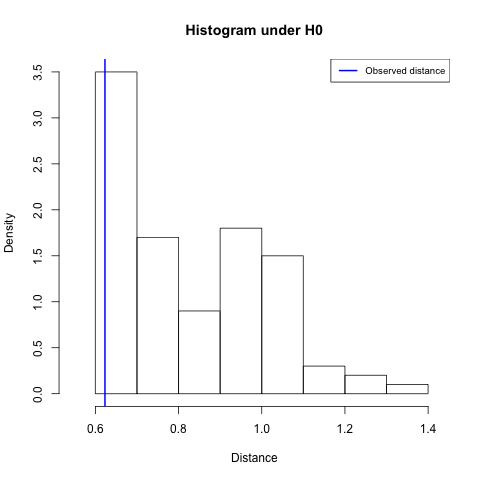

In [14]:
%%R
res.gfit = gfit(target=OBS[,1], sumstat=PRIOR[,7], statistic=mean, nb.replicate=100)
plot(res.gfit, main="Histogram under H0")

In [111]:
%%R
cv.res.rej <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=c(.05,.1, 0.5), method="rejection")
print(summary(cv.res.rej))
plot(cv.res.rej)

Prediction error based on a cross-validation sample of 10

             eq
0.01 0.03407108
0.05 0.03434099
0.1  0.03370091
0.5  0.06817815


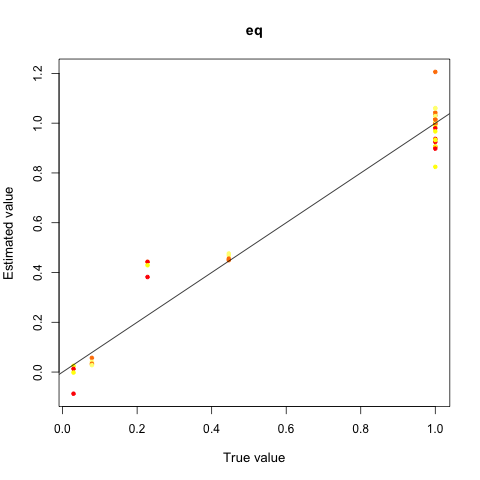

In [34]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=10, tols=c(.01, .05,.1, 0.5), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

In [ ]:
%%R
## This is slow even on toy data
cv.res.net <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=10, tols=c(.01, .05,.1, 0.5), method="neuralnet")
print(summary(cv.res.net))
plot(cv.res.net)

KeyboardInterrupt: 

KeyboardInterrupt: 

KeyboardInterrupt: 

Call: 
abc(target = OBS, param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 7:17], tol = 0.01, method = "loclinear")
Data:
 abc.out$adj.values (151 posterior samples)
Weights:
 abc.out$weights

                           eq
Min.:                  0.4383
Weighted 2.5 % Perc.:  0.6918
Weighted Median:       0.7970
Weighted Mean:         0.7990
Weighted Mode:         0.7996
Weighted 97.5 % Perc.: 0.8997
Max.:                  1.1070
                              eq
Min.:                  0.4382816
Weighted 2.5 % Perc.:  0.6917571
Weighted Median:       0.7970417
Weighted Mean:         0.7989650
Weighted Mode:         0.7996266
Weighted 97.5 % Perc.: 0.8996790
Max.:                  1.1070429


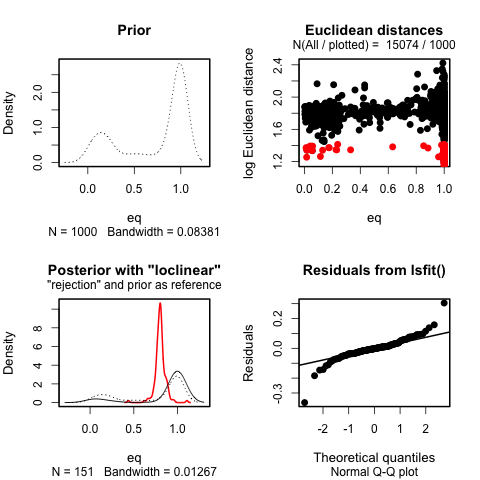

In [35]:
%%R
res.abc = abc(target=OBS, param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7:17], tol=0.01, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"X.equil"])

## Estimate colonization rate using shannon index and 1d pi vector

Prediction error based on a cross-validation sample of 10

            eq
0.01 0.2301760
0.05 0.3694694
0.1  0.5709321
0.5  0.9720246


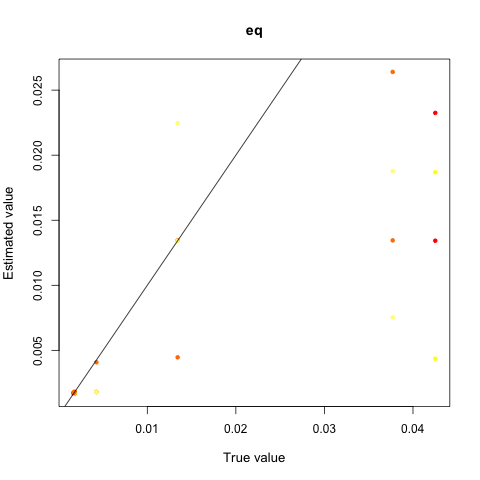

In [39]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"colrate"]), PRIOR[,7:17], nval=10, tols=c(.01, .05,.1, 0.5), method="rejection")
print(summary(cv.res.reg))
plot(cv.res.reg)

12345678910
12345678910
Call: 
abc(target = OBS, param = data.frame(colrate = PRIOR[, "colrate"]), 
    sumstat = PRIOR[, 7:17], tol = 0.05, method = "neuralnet")
Data:
 abc.out$adj.values (754 posterior samples)
Weights:
 abc.out$weights

                       colrate
Min.:                  -0.0013
Weighted 2.5 % Perc.:   0.0008
Weighted Median:        0.0017
Weighted Mean:          0.0016
Weighted Mode:          0.0017
Weighted 97.5 % Perc.:  0.0027
Max.:                   0.0178
                             colrate
Min.:                  -0.0013154145
Weighted 2.5 % Perc.:   0.0008157211
Weighted Median:        0.0016926724
Weighted Mean:          0.0016133925
Weighted Mode:          0.0017398779
Weighted 97.5 % Perc.:  0.0027239163
Max.:                   0.0178428879


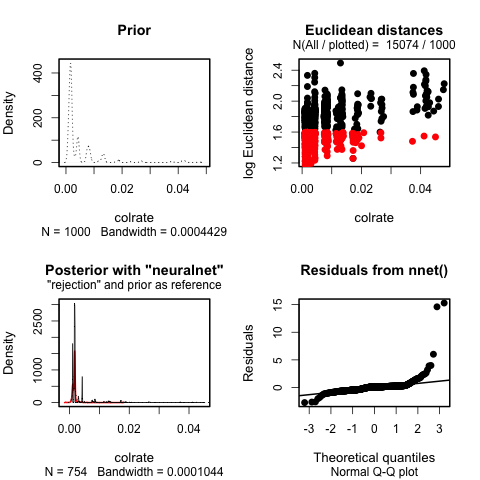

In [42]:
%%R
res.abc = abc(target=OBS, param=data.frame(colrate=PRIOR[,"colrate"]), sumstat=PRIOR[,7:17], tol=0.05, method="neuralnet")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"colrate"])

## Estimate shannon using only 1d pi vector

Prediction error based on a cross-validation sample of 50

           shan
0.001 0.8633722
0.005 0.1936671
0.01  0.2339774
0.05  0.2472949
0.1   0.2476788


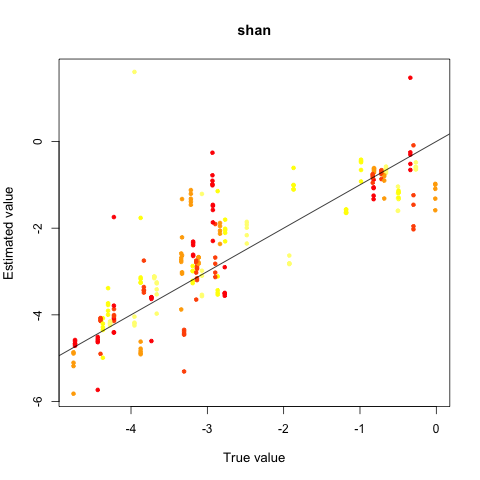

In [55]:
%%R
cv.res.reg <- cv4abc(data.frame(shan=PRIOR[,"shannon"]), PRIOR[,8:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS[2:11], param = data.frame(shan = PRIOR[, "shannon"]), 
    sumstat = PRIOR[, 8:17], tol = 0.001, method = "loclinear")
Data:
 abc.out$adj.values (16 posterior samples)
Weights:
 abc.out$weights

                          shan
Min.:                  -3.0360
Weighted 2.5 % Perc.:  -2.9576
Weighted Median:       -2.6933
Weighted Mean:         -2.6948
Weighted Mode:         -2.6715
Weighted 97.5 % Perc.: -2.3043
Max.:                  -2.3043
                            shan
Min.:                  -3.036029
Weighted 2.5 % Perc.:  -2.957634
Weighted Median:       -2.693337
Weighted Mean:         -2.694795
Weighted Mode:         -2.671530
Weighted 97.5 % Perc.: -2.304316
Max.:                  -2.304316


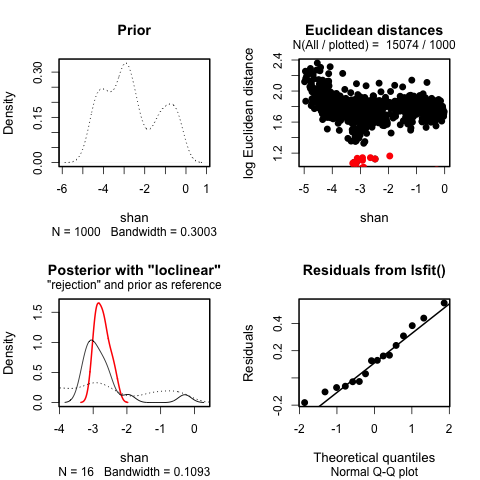

In [58]:
%%R
res.abc = abc(target=OBS[2:11], param=data.frame(shan=PRIOR[,"shannon"]), sumstat=PRIOR[,8:17], tol=0.001, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"shannon"])

## Estimate %equil using only 1d pi vector

Prediction error based on a cross-validation sample of 20

            eq
0.001 1.127194
0.005 1.075467
0.01  1.144348
0.05  1.367554
0.1   1.352901


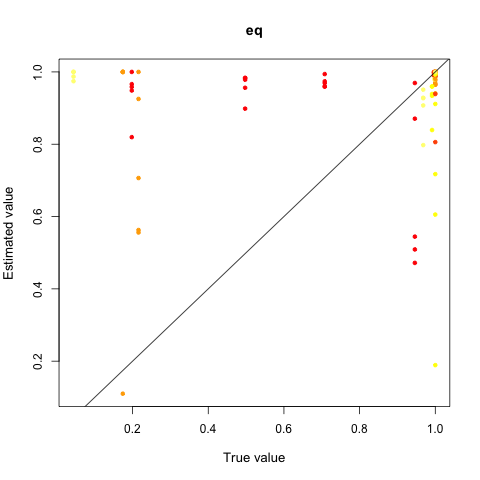

In [61]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,8:17], nval=10, tols=c(.001, .005, .01, .05,.1), method="neuralnet")
print(summary(cv.res.reg))
plot(cv.res.reg)

12345678910
12345678910
Call: 
abc(target = OBS[2:11], param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 8:17], tol = 0.05, method = "neuralnet")
Data:
 abc.out$adj.values (754 posterior samples)
Weights:
 abc.out$weights

                           eq
Min.:                  0.4360
Weighted 2.5 % Perc.:  0.6946
Weighted Median:       0.9877
Weighted Mean:         0.9576
Weighted Mode:         0.9913
Weighted 97.5 % Perc.: 1.0378
Max.:                  1.1163
                              eq
Min.:                  0.4359564
Weighted 2.5 % Perc.:  0.6946349
Weighted Median:       0.9876898
Weighted Mean:         0.9575856
Weighted Mode:         0.9913452
Weighted 97.5 % Perc.: 1.0377606
Max.:                  1.1163487


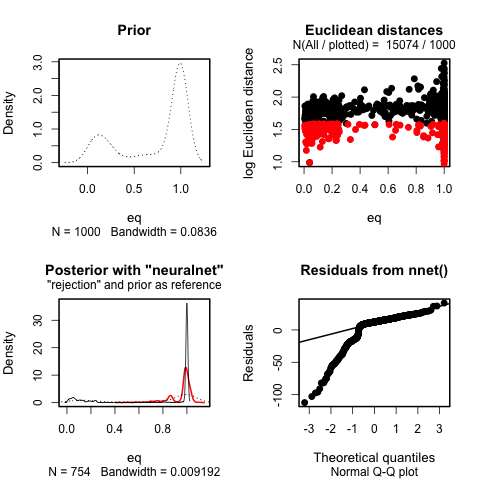

In [64]:
%%R
res.abc = abc(target=OBS[2:11], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,8:17], tol=0.05, method="neuralnet")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"X.equil"])